
Portofolio : ['GLEN.L', 'MRW.L', 'AZN']
Sortino ratio : 67.61
Beta          : 0.53

Portofolio : ['LGEN.L', 'TSCO', 'GSK']
Sortino ratio : 41.46
Beta          : 0.66

Download and calculation time: 3.8s


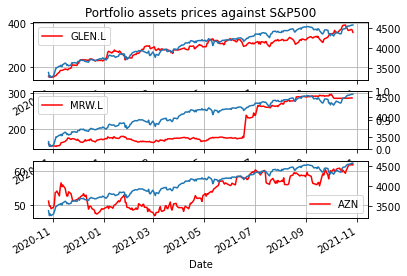

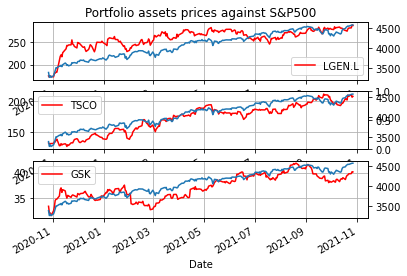

In [1]:
%matplotlib inline
import yfinance as yf
import pandas as pd 
from time import time
import numpy as np
import matplotlib.pyplot as plt

#Portfolios
port1_tickers = ["GLEN.L", "MRW.L", "AZN"]
port2_tickers = ["LGEN.L", "TSCO", "GSK"]

#SONIA 15/10/2021, Risk free rate
Rf = 0.0502 

def sortino(portfolio, Rf):
    """
    Calculates the Sortino Ratio of a portfolio.
    Args:
        portfolio::[str]
            List of the tickers of the portfolio
        Rf::float
            Risk free rate
    Returns: 
        Sortino Ratio::float
            The Sortino ratio of the portfolio
    """
    data=yf.download(portfolio, period="1y", progress=False) #Downloading the past year stock prices
    L_annual_return, L_asset_returns = [],[]  
    
    #We're going to calculate the annual return and the daily return rate for each asset
    for asset in portfolio : 
        #We discard the NaN values and convert the dataframe to an array
        #Arrays are easier to manipulate
        stock = data['Adj Close', asset].dropna().to_numpy() #Adjusted Closing prices are used
        
        #Vectorized calculation of the annual return and the daily price variation.
        #This will allow to have a representative standard deviation.
        L_annual_return.append(stock[-1]/stock[0]-1)
        L_asset_returns.append(stock[1:]/stock[:-1]-1)
    
    #The portfolio return is the mean of every asset return
    Rp = np.mean(L_annual_return) #np.mean() works because the assets are equally weighted
    L_asset_returns = np.array([x for sublist in L_asset_returns for x in sublist]) #flattening the price variation array
    #We calculate the downside deviation only with negative returns.
    std_dr = np.sqrt(np.sum(L_asset_returns[L_asset_returns<0]**2)/len(L_asset_returns))
    
    return round((Rp-Rf)/std_dr,2) #Sortino rate formula


def beta(portfolio):
    """
    Calculates the Beta ratio of a portfolio.
    Args:
        portfolio::[str]
            List of the tickers of the portfolio
    Returns: 
        beta::float
            The Beta ration of the portfolio
    """
    #The S&P500 stock prices are downloaded at each iteration to easily handle NaN values which differ from
    #one sotck history to another. This could be improved in the future with dataframe concatenation though.
    L_beta = []
    for asset in portfolio:
        data=yf.download([asset, '^GSPC'], period="1y", progress=False)['Close'].dropna().to_numpy()
        #The beta ratio requires the covariance and the variance which are both provided by the np.cov() function
        cov_matrix = np.cov(np.transpose(data[1:,:]/data[:-1,]))
        L_beta.append(cov_matrix[0,1]/cov_matrix[1,1])
    return round(np.mean(L_beta),2) #np.mean() works because the assets are equally weighted

def plot_stocks(portfolio):
    """
    Plots the stock prices in the past year against the S&P500.
    The 3 plots are on the same figure to keep it short, however
    if the portfolio was bigger, it would be better to have one plot per stock for improved clarity.
    Args:
        portfolio::[str]
            List of the tickers of the portfolio
    Returns: 
        None
    """
    ticker_sp500 = yf.Ticker('^GSPC')         #^GSPC is the ticker for the S&P500 stock
    df500 = ticker_sp500.history(period="1y") #The stock history of S&P500 is downloaded only once to save time
    fig, ax = plt.subplots(len(portfolio))    #creates as many subplots as there are assets in the portfolio
    ax1=ax[1].twinx()                         #secondary axis
    for i, stock in enumerate(portfolio):
        ticker = yf.Ticker(stock)
        df = ticker.history(period="1y")
        df500['Close'].plot(ax=ax[i].twinx())
        df['Close'].plot(label=stock, c='r', ax=ax[i])
        ax[i].grid()
        ax[i].legend()
    ax[0].set_title("Portfolio assets prices against S&P500")

    
#Results:
t=time()
for portfolio in (port1_tickers, port2_tickers):
    print(f"\nPortofolio : {portfolio}")
    print(f"Sortino ratio : {sortino(portfolio, Rf)}")
    print(f"Beta          : {beta(portfolio)}")
    plot_stocks(portfolio)
    
print(f"\nDownload and calculation time: {round(time()-t,1)}s")